# <center> A Neural Network Model for House Prices

The purpose of this notebook is to build a model (Deep Neural Network) with Keras over Tensorflow. We will see the differents steps to do that. This notebook is split in several parts:

- I.    Importation & Devices Available
- II.   Outliers
- III.  Preprocessing
- IV.   KerasRegressor for Contiunuous features
- V.    Predictions


# <center> I. Importation & Devices Available

Importa the data from: https://www.kaggle.com/hendraherviawan/neural-network-starter-using-keras

In [0]:
import os
import keras

Using TensorFlow backend.


In this tutorial our data is composed to 1460 row with 81 features. 38 continuous features and 43 categorical features. As exposed in the introduction we will use onlly the continuous features to build our first model.

Here the objective is to predict the House Prices. In this case we have a regression model to build.
So our first data we will contain 37 features to explain the 'SalePrice'. We can see the list of features that we will use to build our first model.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('../input/train.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

test = pd.read_csv('../input/test.csv')
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


# <center> II. Outliers

In this small part we will isolate the outliers with an IsolationForest (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). I tried with and without this step and I had a better performance removing these rows.

I haven't analysed the test set but I suppose that our train set looks like more at our data test without these outliers.


In [0]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [0]:
train.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


# <center> III. Preprocessing

To rescale our data we will use the fonction MinMaxScaler of Scikit-learn. I am wondering if it is not interesting to use the same MinMaxScaler for Train and Test !

In [0]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [0]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns
feature_cols = FEATURES

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [0]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.176471,0.159744,0.055205,0.375,0.142857,0.527132,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.636364,0.00,0.130767
433,0.588235,0.102236,0.028107,0.500,0.428571,0.914729,0.800000,0.07250,0.528892,0.0,...,0.000000,0.343407,0.0,0.0,0.0,0.0,0.000000,0.363636,0.00,0.299493
1110,0.823529,0.115016,0.011665,0.625,0.428571,0.953488,0.883333,0.06625,0.000000,0.0,...,0.000000,0.074176,0.0,0.0,0.0,0.0,0.000000,0.454545,1.00,0.326257


# <center> IV. Deep Neural Network for continuous features

With tf.contrib.learn it is very easy to implement a Deep Neural Network. In our example we will have 5 hidden layers with repsectly 200, 100, 50, 25 and 12 units and the function of activation will be Relu.

The optimizer used in our case is an AdaDelta  optimizer.

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=36, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())

feature_cols = training_set[FEATURES]
labels = training_set[LABEL].values

model.fit(np.array(feature_cols), np.array(labels), epochs=100, batch_size=10)

Epoch 1/100
880/880 [==============================] - 0s - loss: 0.0334     
Epoch 2/100
880/880 [==============================] - 0s - loss: 0.0067     
Epoch 3/100
880/880 [==============================] - 0s - loss: 0.0046     
Epoch 4/100
880/880 [==============================] - 0s - loss: 0.0039     
Epoch 5/100
880/880 [==============================] - 0s - loss: 0.0036     
Epoch 6/100
880/880 [==============================] - 0s - loss: 0.0035     
Epoch 7/100
880/880 [==============================] - 0s - loss: 0.0034     
Epoch 8/100
880/880 [==============================] - 0s - loss: 0.0032     
Epoch 9/100
880/880 [==============================] - 0s - loss: 0.0032     
Epoch 10/100
880/880 [==============================] - 0s - loss: 0.0029     
Epoch 11/100
880/880 [==============================] - 0s - loss: 0.0030     
Epoch 12/100
880/880 [==============================] - 0s - loss: 0.0030     
Epoch 13/100
880/880 [==============================] - 0s - 

In [0]:
# Evaluation on the test set created by train_test_split
model.evaluate(np.array(feature_cols), np.array(labels))

 32/880 [>.............................] - ETA: 0s

0.001330266560597176

In [0]:
# Predictions
feature_cols_test = testing_set[FEATURES]
labels_test = testing_set[LABEL].values

y = model.predict(np.array(feature_cols_test))
predictions = list(itertools.islice(y, testing_set.shape[0]))


# <center> V. Predictions and submission

Let's go to prepare our first submission ! Data Preprocessed: checked ! Outlier excluded: checked ! Model built: : checked! Next step: Used our model to make the predictions with the data set Test. And add one graphic to see the difference between the reality and the predictions.

In [0]:
predictions = prepro_y.inverse_transform(np.array(predictions).reshape(434,1))

In [0]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice

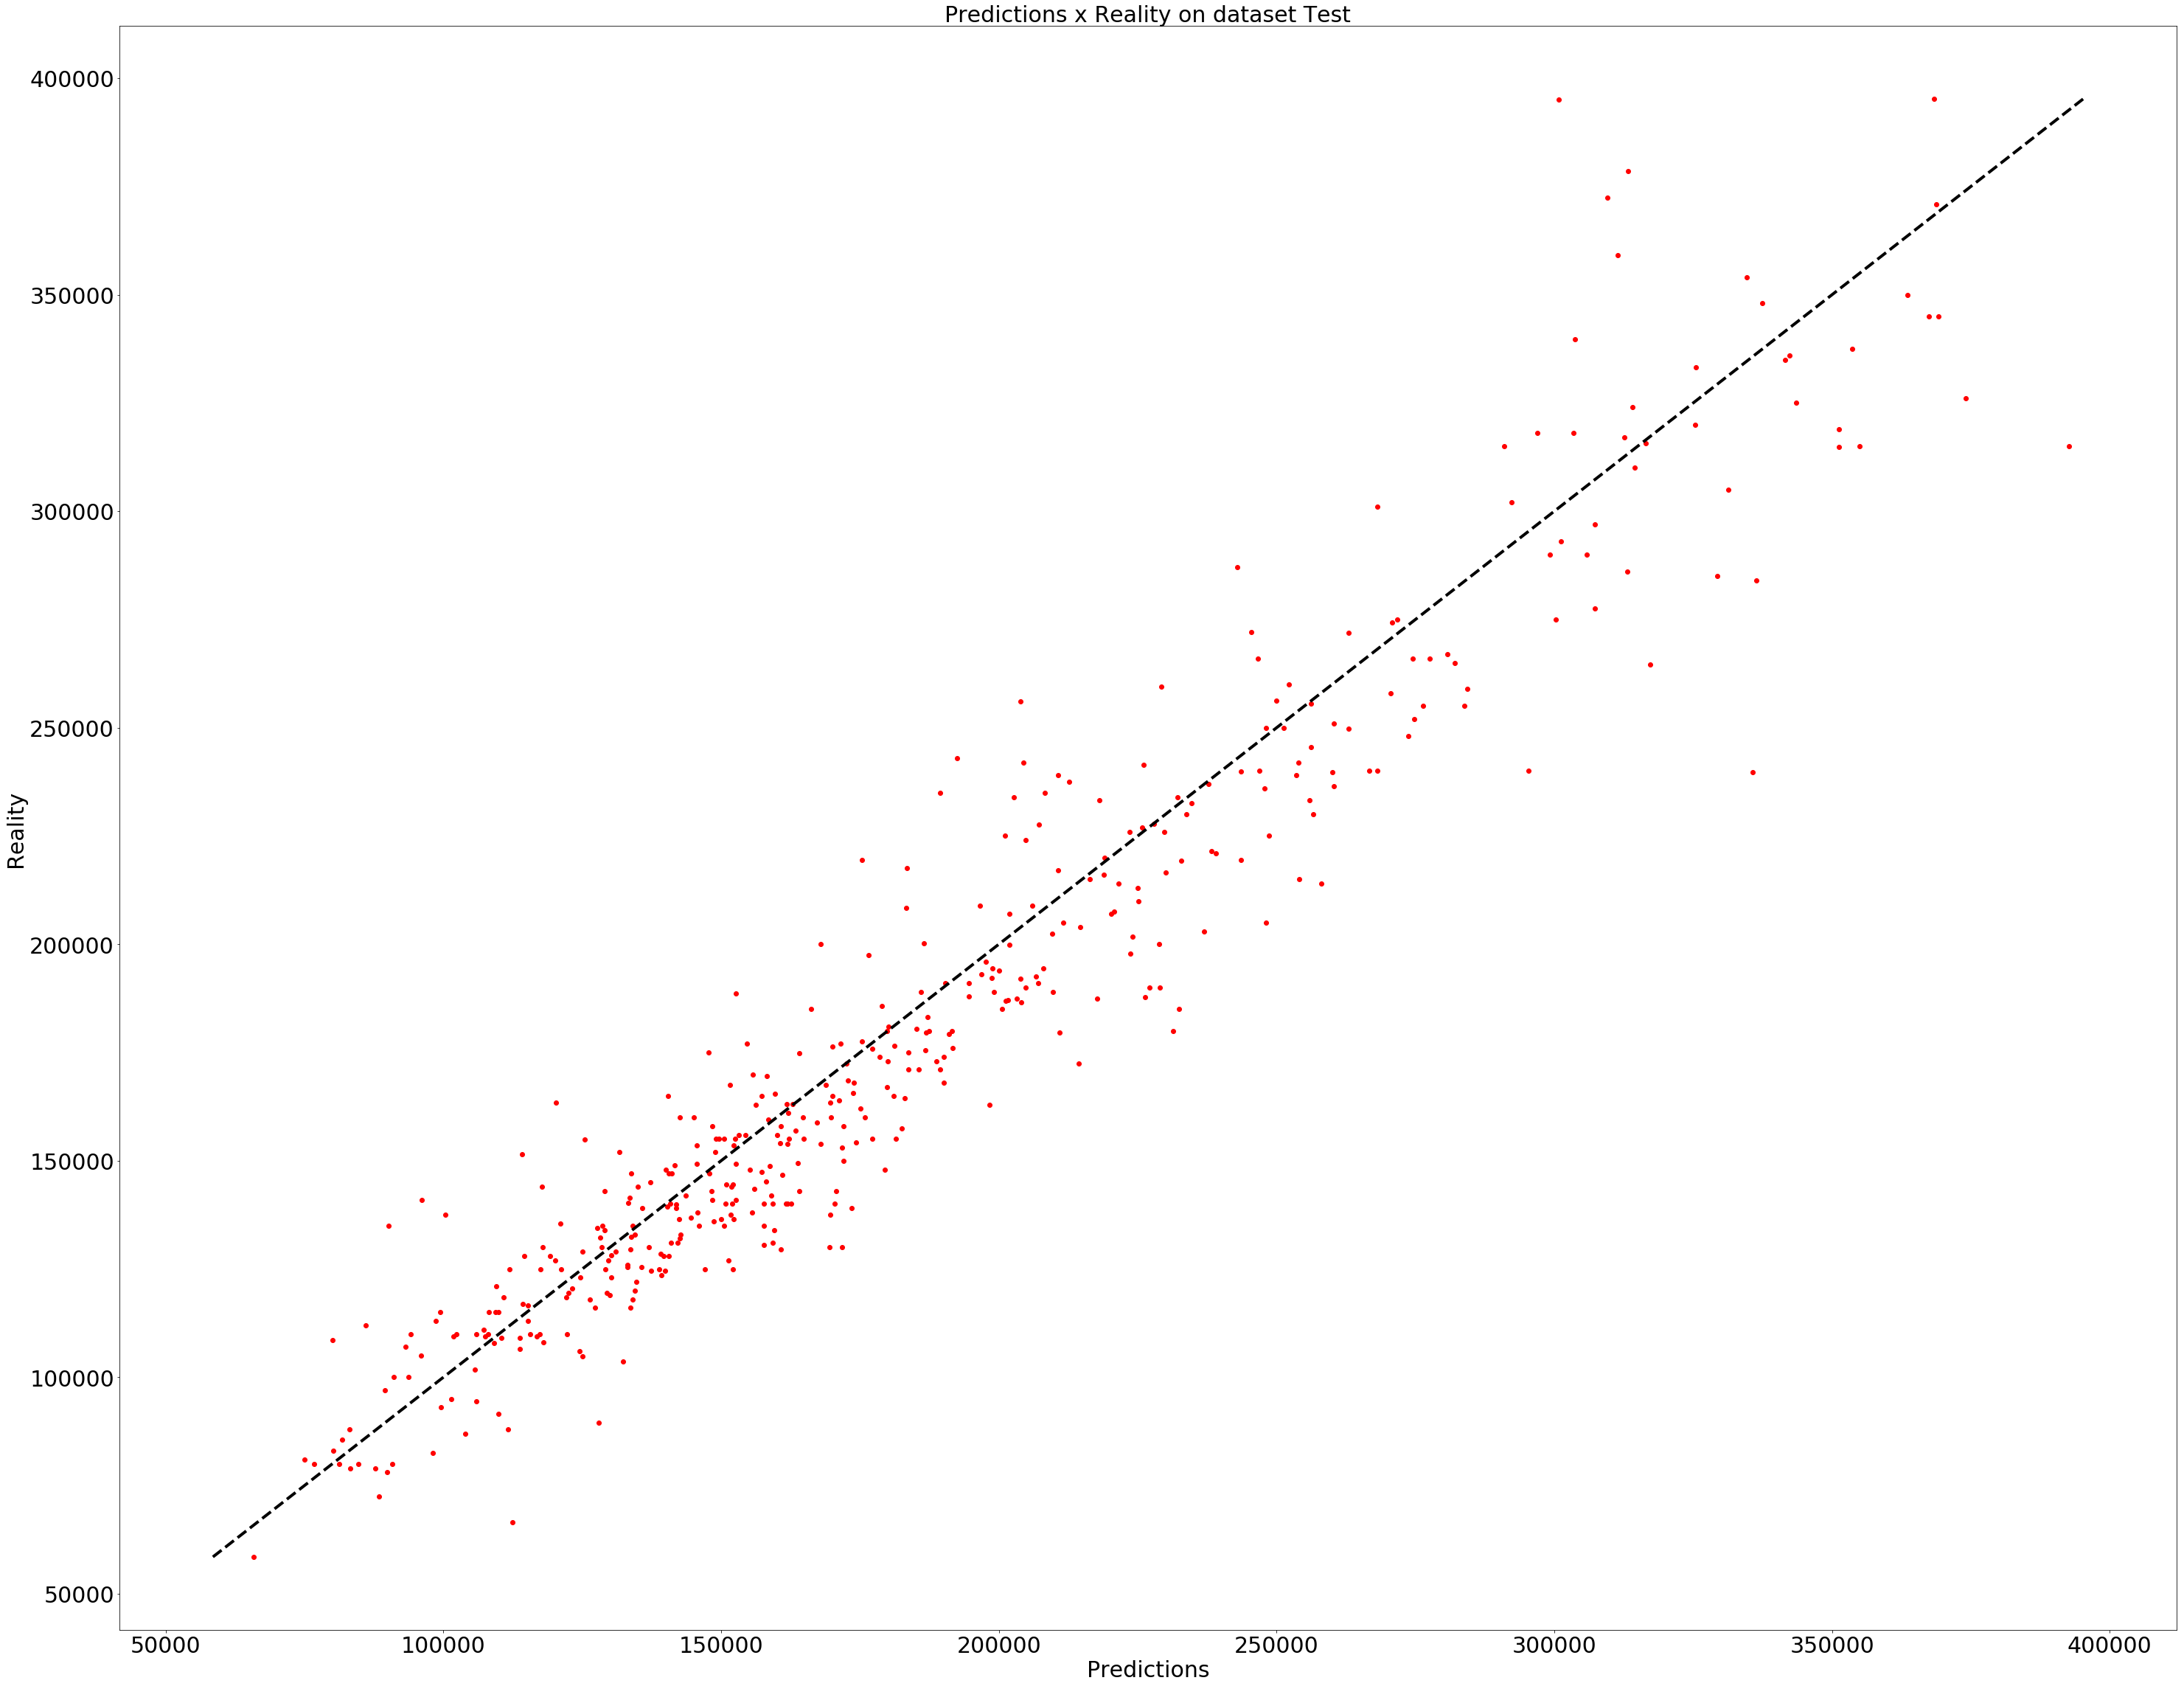

In [0]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [0]:
y_predict = model.predict(np.array(test))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")